## 12d - JackSolar AgriPV Site

May September (idx 2881 : 6552)

Configuration A:
<li>Under 6 ft panels : 1.8288m
<li>Hub height: 6 ft   : 1.8288m  

    
Configuration B:
<li>8 ft panels : 2.4384m
<li>Hub height 8 ft : 2.4384m

Module x = 3 ft
    
Row-to-row spacing: 17 ft --> 5.1816

torquetube: square, diam 15 cm, zgap = 0
modules on portrait
albedo = green grass
 
COMPARE TO:
Open air (no panels)


** Two Methods: **
    - Hourly with Fixed tilt, getTrackerAngle to update tilt of tracker
    - Hourly with gendaylit1axis
    - Cumulatively with gencumsky1axis


## 1. Load Bifacial Radiance and other essential packages

In [2]:
import bifacial_radiance
import numpy as np
import os # this operative system to do the relative-path testfolder for this example.
import pprint    # We will be pretty-printing the trackerdictionary throughout to show its structure.
from pathlib import Path

## 2. Define all the system variables

In [3]:
testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP')

timestamp = 4020 # Noon, June 17th.
simulationName = 'AgriPV_JS'    # Optionally adding a simulation name when defning RadianceObj

#Location
lat = 40.1217  # Given for the project site at Colorado
lon = -105.1310  # Given for the project site at Colorado

# MakeModule Parameters
moduletype='PrismSolar'
numpanels = 1  # This site have 1 module in Y-direction
x = 1  
y = 2
#xgap = 0.15 # Leaving 15 centimeters between modules on x direction
#ygap = 0.10 # Leaving 10 centimeters between modules on y direction
zgap = 0 # no gap to torquetube.
sensorsy = 6  # this will give 6 sensors per module in y-direction
sensorsx = 3   # this will give 3 sensors per module in x-direction

torquetube = True
axisofrotationTorqueTube = True 
diameter = 0.15  # 15 cm diameter for the torquetube
tubetype = 'square'    # Put the right keyword upon reading the document
material = 'black'   # Torque tube of this material (0% reflectivity)

# Scene variables
nMods = 20
nRows = 7
hub_height = 1.8 # meters
pitch = 5.1816 # meters      # Pitch is the known parameter 
albedo = 0.2  #'Grass'     # ground albedo
gcr = y/pitch


cumulativesky = False
limit_angle = 60 # tracker rotation limit angle
angledelta = 0.01 # we will be doing hourly simulation, we want the angle to be as close to real tracking as possible.
backtrack = True 

In [10]:
test_folder_fmt = 'Hour_{}' 
epwfile = r'C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\EPWs\USA_CO_Boulder-Broomfield-Jefferson.County.AP.724699_TMY3.epw'

# For making a pretty Image

In [ ]:
#for idx in range(270, 283):
for idx in range(272, 273):

    test_folderinner = os.path.join(testfolder, test_folder_fmt.format(f'{idx:04}'))
    if not os.path.exists(test_folderinner):
        os.makedirs(test_folderinner)

    rad_obj = bifacial_radiance.RadianceObj(simulationName,path = test_folderinner)  # Create a RadianceObj 'object'
    rad_obj.setGround(albedo) 
    metdata = rad_obj.readWeatherFile(epwfile, label='center', coerce_year=2021)
    solpos = rad_obj.metdata.solpos.iloc[idx]
    zen = float(solpos.zenith)
    azm = float(solpos.azimuth) - 180
    dni = rad_obj.metdata.dni[idx]
    dhi = rad_obj.metdata.dhi[idx]
    rad_obj.gendaylit(idx)
  # rad_obj.gendaylit2manual(dni, dhi, 90 - zen, azm)
    #print(rad_obj.metdata.datetime[idx])
    tilt = round(rad_obj.getSingleTimestampTrackerAngle(rad_obj.metdata, idx, gcr, limit_angle=65),1)
    sceneDict = {'pitch': pitch, 'tilt': tilt, 'azimuth': 90, 'hub_height':hub_height, 'nMods':nMods, 'nRows': nRows}  
    scene = rad_obj.makeScene(moduletype=moduletype,sceneDict=sceneDict)
    octfile = rad_obj.makeOct()  


rvu -vf views\front.vp -e .0265652 -vp 2 -21 2.5 -vd 0 1 0 AgriPV_JS.oct


cd C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP

# GHI Calculations from EPW

In [29]:
# BOULDER

starts = [2881, 3626, 4346, 5090, 5835]
ends = [3621, 4341, 5085, 5829, 6550]

ghi_Boulder = []
for ii in range(0, len(starts)):
    start = starts[ii]
    end = ends[ii]
    ghi_Boulder.append(metdata.ghi[start:end].sum())
print(" GHI Boulder Monthly May to September Wh/m2:", ghi_Boulder)


 GHI Boulder Monthly May to September Wh/m2: [197035, 206508, 201174, 177165, 146539]


# GHI Calculations with bifacial_radiance raytrace

# Warning: Not working currently becuase Gencumsky/readweatherfile not restricting, so all results equal the YEAR Total

In [6]:
import datetime
import pandas as pd

In [25]:
startdt = datetime.datetime(2021,5,1,1)
enddt = datetime.datetime(2021,5,31,23)
simulationName = 'EMPTYFIELD'
rad_obj = bifacial_radiance.RadianceObj(simulationName, path=testfolder)  # Create a RadianceObj 'object'
rad_obj.setGround(albedo) 
metdata = rad_obj.readWeatherFile(epwfile, label='center', coerce_year=2021)
rad_obj.genCumSky()
#print(rad_obj.metdata.datetime[idx])
sceneDict = {'pitch': pitch, 'tilt': 0, 'azimuth': 90, 'hub_height':-0.2, 'nMods':1, 'nRows': 1}  
scene = rad_obj.makeScene(moduletype=moduletype,sceneDict=sceneDict)
octfile = rad_obj.makeOct()  
analysis = bifacial_radiance.AnalysisObj()
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=1)
frontscan['zstart'] = 0.5
frontdict, backdict = analysis.analysis(octfile = octfile, name='FIELDTotal', frontscan=frontscan, backscan=backscan)
resname = os.path.join(testfolder, 'results')
resname = os.path.join(resname, 'irr_FIELDTotal.csv')
data = pd.read_csv(resname)
print("YEAR TOTAL:", data['Wm2Front'])

path = C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
start: 2021-01-01 01:00:00
end: 2021-12-31 23:00:00
Saving file EPWs\epw_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact timestamp in input Weather File
message: There were 4561 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created EMPTYFIELD.oct
Linescan in process: FIELDTotal_Front
Linescan in process: FIELDTotal_Back
Saved: results\irr_FIELDTotal.csv
YEAR TOTAL: 0    1615258.0
Name: Wm2Front, dtype: float64


In [18]:
startdt = datetime.datetime(2021,5,1,1)
enddt = datetime.datetime(2021,9,30,23)
simulationName = 'EMPTYFIELD'
rad_obj = bifacial_radiance.RadianceObj(simulationName, path=testfolder)  # Create a RadianceObj 'object'
rad_obj.setGround(albedo) 
metdata = rad_obj.readWeatherFile(epwfile, label='center', coerce_year=2021)
rad_obj.genCumSky(startdt=startdt, enddt=enddt)
#print(rad_obj.metdata.datetime[idx])
sceneDict = {'pitch': pitch, 'tilt': 0, 'azimuth': 90, 'hub_height':-0.2, 'nMods':1, 'nRows': 1}  
scene = rad_obj.makeScene(moduletype=moduletype,sceneDict=sceneDict)
octfile = rad_obj.makeOct()  
analysis = bifacial_radiance.AnalysisObj()
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=1)
frontscan['zstart'] = 0.5
frontdict, backdict = analysis.analysis(octfile = octfile, name='FIELDTotal', frontscan=frontscan, backscan=backscan)
resname = os.path.join(testfolder, 'results')
resname = os.path.join(resname, 'irr_FIELDTotal.csv')
data = pd.read_csv(resname)
print("FIELD TOTAL Season:", data['Wm2Front'])

path = C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
start: 2021-01-01 01:00:00
end: 2021-12-31 23:00:00
Saving file EPWs\epw_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact timestamp in input Weather File
message: There were 4561 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created EMPTYFIELD.oct
Linescan in process: FIELDTotal_Front
Linescan in process: FIELDTotal_Back
Saved: results\irr_FIELDTotal.csv
FIELD TOTAL Season: 0    1626793.0
Name: Wm2Front, dtype: float64


In [19]:
startdt = datetime.datetime(2021,5,1,1)
enddt = datetime.datetime(2021,5,31,23)
simulationName = 'EMPTYFIELD'
rad_obj = bifacial_radiance.RadianceObj(simulationName, path=testfolder)  # Create a RadianceObj 'object'
rad_obj.setGround(albedo) 
metdata = rad_obj.readWeatherFile(epwfile, label='center', coerce_year=2021)
rad_obj.genCumSky(startdt=startdt, enddt=enddt)
#print(rad_obj.metdata.datetime[idx])
sceneDict = {'pitch': pitch, 'tilt': 0, 'azimuth': 90, 'hub_height':-0.2, 'nMods':1, 'nRows': 1}  
scene = rad_obj.makeScene(moduletype=moduletype,sceneDict=sceneDict)
octfile = rad_obj.makeOct()  
analysis = bifacial_radiance.AnalysisObj()
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=1)
frontscan['zstart'] = 0.5
frontdict, backdict = analysis.analysis(octfile = octfile, name='FIELDTotal', frontscan=frontscan, backscan=backscan)
resname = os.path.join(testfolder, 'results')
resname = os.path.join(resname, 'irr_FIELDTotal.csv')
data = pd.read_csv(resname)
print("MAY TOTAL Season:", data['Wm2Front'])

path = C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
start: 2021-01-01 01:00:00
end: 2021-12-31 23:00:00
Saving file EPWs\epw_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact timestamp in input Weather File
message: There were 4561 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created EMPTYFIELD.oct
Linescan in process: FIELDTotal_Front
Linescan in process: FIELDTotal_Back
Saved: results\irr_FIELDTotal.csv
MAY TOTAL Season: 0    1627991.0
Name: Wm2Front, dtype: float64


In [22]:
startdt = datetime.datetime(2021,6,1,1)
enddt = datetime.datetime(2021,6,30,23)
simulationName = 'EMPTYFIELD'
rad_obj = bifacial_radiance.RadianceObj(simulationName, path=testfolder)  # Create a RadianceObj 'object'
rad_obj.setGround(albedo) 
metdata = rad_obj.readWeatherFile(epwfile, label='center', coerce_year=2021)
rad_obj.genCumSky(startdt=startdt, enddt=enddt)
#print(rad_obj.metdata.datetime[idx])
sceneDict = {'pitch': pitch, 'tilt': 0, 'azimuth': 90, 'hub_height':-0.2, 'nMods':1, 'nRows': 1}  
scene = rad_obj.makeScene(moduletype=moduletype,sceneDict=sceneDict)
octfile = rad_obj.makeOct()  
analysis = bifacial_radiance.AnalysisObj()
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=1)
frontscan['zstart'] = 0.5
frontdict, backdict = analysis.analysis(octfile = octfile, name='FIELDTotal', frontscan=frontscan, backscan=backscan)
resname = os.path.join(testfolder, 'results')
resname = os.path.join(resname, 'irr_FIELDTotal.csv')
data = pd.read_csv(resname)
print("June TOTAL Season:", data['Wm2Front'])

path = C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
start: 2021-01-01 01:00:00
end: 2021-12-31 23:00:00
Saving file EPWs\epw_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact timestamp in input Weather File
message: There were 4561 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created EMPTYFIELD.oct
Linescan in process: FIELDTotal_Front
Linescan in process: FIELDTotal_Back
Saved: results\irr_FIELDTotal.csv
June TOTAL Season: 0    1630760.0
Name: Wm2Front, dtype: float64


In [21]:
startdt = datetime.datetime(2021,7,1,1)
enddt = datetime.datetime(2021,7,31,23)
simulationName = 'EMPTYFIELD'
rad_obj = bifacial_radiance.RadianceObj(simulationName, path=testfolder)  # Create a RadianceObj 'object'
rad_obj.setGround(albedo) 
metdata = rad_obj.readWeatherFile(epwfile, label='center', coerce_year=2021)
rad_obj.genCumSky(startdt=startdt, enddt=enddt)
#print(rad_obj.metdata.datetime[idx])
sceneDict = {'pitch': pitch, 'tilt': 0, 'azimuth': 90, 'hub_height':-0.2, 'nMods':1, 'nRows': 1}  
scene = rad_obj.makeScene(moduletype=moduletype,sceneDict=sceneDict)
octfile = rad_obj.makeOct()  
analysis = bifacial_radiance.AnalysisObj()
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=1)
frontscan['zstart'] = 0.5
frontdict, backdict = analysis.analysis(octfile = octfile, name='FIELDTotal', frontscan=frontscan, backscan=backscan)
resname = os.path.join(testfolder, 'results')
resname = os.path.join(resname, 'irr_FIELDTotal.csv')
data = pd.read_csv(resname)
print("July TOTAL Season:", data['Wm2Front'])

path = C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
start: 2021-01-01 01:00:00
end: 2021-12-31 23:00:00
Saving file EPWs\epw_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact timestamp in input Weather File
message: There were 4561 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created EMPTYFIELD.oct
Linescan in process: FIELDTotal_Front
Linescan in process: FIELDTotal_Back
Saved: results\irr_FIELDTotal.csv
July TOTAL Season: 0    1650217.0
Name: Wm2Front, dtype: float64


In [23]:
startdt = datetime.datetime(2021,8,1,1)
enddt = datetime.datetime(2021,8,31,23)
simulationName = 'EMPTYFIELD'
rad_obj = bifacial_radiance.RadianceObj(simulationName, path=testfolder)  # Create a RadianceObj 'object'
rad_obj.setGround(albedo) 
metdata = rad_obj.readWeatherFile(epwfile, label='center', coerce_year=2021)
rad_obj.genCumSky(startdt=startdt, enddt=enddt)
#print(rad_obj.metdata.datetime[idx])
sceneDict = {'pitch': pitch, 'tilt': 0, 'azimuth': 90, 'hub_height':-0.2, 'nMods':1, 'nRows': 1}  
scene = rad_obj.makeScene(moduletype=moduletype,sceneDict=sceneDict)
octfile = rad_obj.makeOct()  
analysis = bifacial_radiance.AnalysisObj()
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=1)
frontscan['zstart'] = 0.5
frontdict, backdict = analysis.analysis(octfile = octfile, name='FIELDTotal', frontscan=frontscan, backscan=backscan)
resname = os.path.join(testfolder, 'results')
resname = os.path.join(resname, 'irr_FIELDTotal.csv')
data = pd.read_csv(resname)
print("August TOTAL Season:", data['Wm2Front'])

path = C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
start: 2021-01-01 01:00:00
end: 2021-12-31 23:00:00
Saving file EPWs\epw_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact timestamp in input Weather File
message: There were 4561 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created EMPTYFIELD.oct
Linescan in process: FIELDTotal_Front
Linescan in process: FIELDTotal_Back
Saved: results\irr_FIELDTotal.csv
August TOTAL Season: 0    1637887.0
Name: Wm2Front, dtype: float64


In [24]:
startdt = datetime.datetime(2021,9,1,1)
enddt = datetime.datetime(2021,9,30,23)
simulationName = 'EMPTYFIELD'
rad_obj = bifacial_radiance.RadianceObj(simulationName, path=testfolder)  # Create a RadianceObj 'object'
rad_obj.setGround(albedo) 
metdata = rad_obj.readWeatherFile(epwfile, label='center', coerce_year=2021)
rad_obj.genCumSky(startdt=startdt, enddt=enddt)
#print(rad_obj.metdata.datetime[idx])
sceneDict = {'pitch': pitch, 'tilt': 0, 'azimuth': 90, 'hub_height':-0.2, 'nMods':1, 'nRows': 1}  
scene = rad_obj.makeScene(moduletype=moduletype,sceneDict=sceneDict)
octfile = rad_obj.makeOct()  
analysis = bifacial_radiance.AnalysisObj()
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=1)
frontscan['zstart'] = 0.5
frontdict, backdict = analysis.analysis(octfile = octfile, name='FIELDTotal', frontscan=frontscan, backscan=backscan)
resname = os.path.join(testfolder, 'results')
resname = os.path.join(resname, 'irr_FIELDTotal.csv')
data = pd.read_csv(resname)
print("SEPTEMBER TOTAL Season:", data['Wm2Front'])

path = C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
start: 2021-01-01 01:00:00
end: 2021-12-31 23:00:00
Saving file EPWs\epw_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact timestamp in input Weather File
message: There were 4561 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created EMPTYFIELD.oct
Linescan in process: FIELDTotal_Front
Linescan in process: FIELDTotal_Back
Saved: results\irr_FIELDTotal.csv
SEPTEMBER TOTAL Season: 0    1621738.0
Name: Wm2Front, dtype: float64


## COMPILE PUERTO RICO RESULTS

In [69]:
# PUERTO RICO
epwfile2 = r'C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\PuertoRico\EPWs\PRI_Mercedita.AP.785203_TMY3.epw'
metdata = rad_obj.readWeatherFile(epwfile2)

ghi_PR=[]
for ii in range(0, len(starts)):
    start = starts[ii]
    end = ends[ii]
    ghi_PR.append(metdata.ghi[start:end].sum())
ghi_PR    

puerto_Rico = [179206, 188133, 193847, 191882, 162560]  # Wh/m2
puerto_Rico_YEAR = metdata.ghi.sum()  # Wh/m2

start: 1991-01-01 01:00:00
end: 1994-12-31 23:00:00
Saving file EPWs\epw_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos


In [51]:
testfolder = r'C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\PuertoRico\results'
lat = lat = 18.202142
ft2m = 0.3048
y = 1

# Loops
clearance_heights = np.array([6.0, 8.0, 10.0])* ft2m
xgaps = np.array([2, 3, 4]) * ft2m
Ds = np.array([2, 3, 4]) * ft2m    # D is a variable that represents the spacing between rows, not-considering the collector areas.
tilts = [round(lat), 10]


In [62]:
# irr_Coffee_ch_1.8_xgap_0.6_tilt_18_pitch_1.6_Front&Back.csv

ch_all = []
xgap_all = []
tilt_all = []
pitch_all = []
FrontIrrad = []
RearIrrad = []
GroundIrrad = []

for ch in range (0, len(clearance_heights)):
    
    clearance_height = clearance_heights[ch]
    for xx in range (0, len(xgaps)):
        
        xgap = xgaps[xx]

        for tt in range (0, len(tilts)):
        
            tilt = tilts[tt]
            for dd in range (0, len(Ds)):
                pitch = y * np.cos(np.radians(tilt))+Ds[dd]


                sim_name = ('irr_Coffee'+'_ch_'+str(round(clearance_height,1))+
                                '_xgap_'+str(round(xgap,1))+\
                                '_tilt_'+str(round(tilt,1))+
                                '_pitch_'+str(round(pitch,1))+'_Front&Back.csv')

                sim_name2 = ('irr_Coffee'+'_ch_'+str(round(clearance_height,1))+
                                '_xgap_'+str(round(xgap,1))+\
                                '_tilt_'+str(round(tilt,1))+
                                '_pitch_'+str(round(pitch,1))+'_Ground&Back.csv')

                ch_all.append(clearance_height)
                xgap_all.append(xgap)
                tilt_all.append(tilt)
                pitch_all.append(pitch)
                data = pd.read_csv(os.path.join(testfolder, sim_name))
                FrontIrrad.append(data['Wm2Front'].item())
                RearIrrad.append(data['Wm2Back'].item())
                data = pd.read_csv(os.path.join(testfolder, sim_name2))
                GroundIrrad.append(data['Wm2Front'].item())


In [64]:
ch_all = pd.Series(ch_all, name='clearance_height')
xgap_all = pd.Series(xgap_all, name='xgap')
tilt_all = pd.Series(tilt_all, name='tilt')
pitch_all = pd.Series(pitch_all, name='pitch')
FrontIrrad = pd.Series(FrontIrrad, name='FrontIrrad')
RearIrrad = pd.Series(RearIrrad, name='RearIrrad')
GroundIrrad = pd.Series(GroundIrrad, name='GroundIrrad')



In [77]:
df = pd.concat([ch_all, xgap_all, tilt_all, pitch_all, FrontIrrad, RearIrrad, GroundIrrad], axis=1)
df.head()

,clearance_height,xgap,tilt,pitch,FrontIrrad,RearIrrad,GroundIrrad
0,1.8288,0.6096,18,1.560657,2000070.0,267628.8,1118029.0
1,1.8288,0.6096,18,1.865457,2009647.0,300637.0,1281753.0
2,1.8288,0.6096,18,2.170257,2012604.0,325479.9,1368239.0
3,1.8288,0.6096,10,1.594408,1998602.0,274611.8,1133789.0
4,1.8288,0.6096,10,1.899208,2002028.0,305427.4,1342856.0


In [82]:
df[['GroundIrrad_percent_GHI']] = df[['GroundIrrad']]*100/puerto_Rico_YEAR
df['FrontIrrad_percent_GHI'] = df['FrontIrrad']*100/puerto_Rico_YEAR
df['RearIrrad_percent_GHI'] = df['RearIrrad']*100/puerto_Rico_YEAR
df['BifacialGain'] = df['RearIrrad']*0.65*100/df['FrontIrrad']

In [124]:
print(df['GroundIrrad_percent_GHI'].min())
print(df['GroundIrrad_percent_GHI'].max())

55.8368342621305
78.38497688728512


In [140]:
#tilt[18, 10]
#clearance_heights = [6,8,10]

TypeError: 'int' object is not subscriptable

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


xgap         0.6        0.9        1.2
pitch                                 
1.6    56.996927  61.772542  66.208633
1.9    63.293483  66.704369  71.058353
2.2    69.024555  72.255017  75.495508


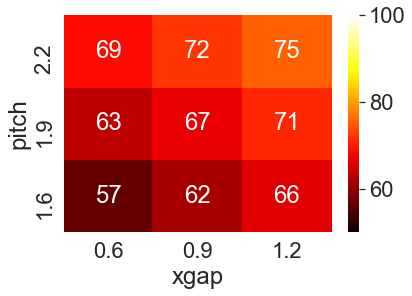

In [151]:
import seaborn as sns 
import matplotlib.pyplot as plt

df2=df.loc[df['tilt']==tilts[1]]
df3 = df2.loc[df2['clearance_height']==clearance_heights[2]]
df3['pitch']=df3['pitch'].round(1)
df3['xgap']=df3['xgap'].round(1)

sns.set(font_scale=2) 
table = df3.pivot('pitch', 'xgap', 'GroundIrrad_percent_GHI')
ax = sns.heatmap(table, cmap='hot', vmin = 50, vmax= 100, annot=True)
ax.invert_yaxis()
print(table)
plt.show()